In [115]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import RandomSampler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

In [2]:
# Data augmentation functions
def rotate_point_cloud(points):
    """Rotate the point cloud around the z-axis."""
    angle = np.random.uniform(0, 2 * np.pi)
    cos_val = np.cos(angle)
    sin_val = np.sin(angle)
    rotation_matrix = np.array([
        [cos_val, -sin_val, 0],
        [sin_val, cos_val, 0],
        [0, 0, 1]
    ])
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points

def translate_point_cloud(points):
    """Translate the point cloud by a small random vector."""
    translation_vector = np.random.uniform(-0.2, 0.2, size=(1, 3))
    translated_points = points + translation_vector
    return translated_points

def scale_point_cloud(points):
    """Scale the point cloud by a random factor."""
    scale_factor = np.random.uniform(0.8, 1.2)
    scaled_points = points * scale_factor
    return scaled_points

def jitter_point_cloud(points):
    """Add Gaussian noise to the point cloud."""
    noise = np.random.normal(0, 0.01, points.shape)
    jittered_points = points + noise
    return jittered_points

def augment_point_cloud(points):
    points = rotate_point_cloud(points)
    points = translate_point_cloud(points)
    points = scale_point_cloud(points)
    points = jitter_point_cloud(points)
    return points

In [23]:


def normalize_point_cloud(points):
    """Normalize the point cloud."""
    centroid = np.mean(points, axis=0)
    points -= centroid
    max_dist = np.max(np.sqrt(np.sum(points**2, axis=1)))
    points /= max_dist
    return points

class PointCloudDataset(Dataset):
    def __init__(self, data_dir, augment=False):
        self.data_dir = data_dir
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        data = np.load(file_path)
        points = data[:, :3]  
        labels = data[:, 3]   
        
        if self.augment:
            points = augment_point_cloud(points)
            
        
        points = normalize_point_cloud(points)
        
        
        points = torch.FloatTensor(points)
        labels = torch.FloatTensor(labels)  # Convert labels to float for BCELoss
        
        return points, labels



def collate_fn(batch):
 
    max_points = min(1024, max(item[0].size(0) for item in batch))  # Limit to 1024 points

    padded_points = []
    padded_labels = []

    for points, labels in batch:
        
        if points.size(0) > max_points:
            points = points[:max_points]
            labels = labels[:max_points]
        
        
        pad_size = max_points - points.size(0)
        
   
        padded = torch.nn.functional.pad(points, (0, 0, 0, pad_size)) 
        padded_points.append(padded)
        

        padded_label = torch.cat((labels, torch.zeros(pad_size)))
        padded_labels.append(padded_label)


    return torch.stack(padded_points), torch.stack(padded_labels)

In [105]:
import torch
import torch.nn as nn

class PointNetPlusPlus(nn.Module):
    def __init__(self):
        super(PointNetPlusPlus, self).__init__()

        # First MLP block with dropout
        self.mlp1 = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.bn1 = nn.BatchNorm1d(512)  

       
        self.residual1 = nn.Linear(3, 512) 

       
        self.abstraction = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.mlp2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)  
        )

       
        self.residual2 = nn.Linear(128, 1) 

        self.mlp3 = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1) 
        )
        
       
        self.residual3 = nn.Linear(1, 1)  

    def forward(self, x):
        # Apply the first MLP
        identity1 = self.residual1(x)
        x = self.mlp1(x)
        x = x + identity1

        # Apply the second MLP with residual connection
        x = self.abstraction(x)
        identity2 = self.residual2(x)
        x = self.mlp2(x)
        x = x + identity2

        # Apply the third MLP with residual connection
        identity3 = self.residual3(x)
        x = self.mlp3(x)
        x = x + identity3

        # Final output
        return x.squeeze(-1) 


In [107]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import os
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

data_dir = '/home/jovyan/dlrv_project_ws/kp_filtered data/' #provide input directory of the filtered data

# Hyperparameters
batch_size = 16
num_epochs = 100
learning_rate = 0.001
step_size = 20  
gamma = 0.7  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset and DataLoader
train_dataset = PointCloudDataset(data_dir=data_dir, augment=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_dataset = PointCloudDataset(data_dir=data_dir, augment=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Model
model = PointNetPlusPlus().to(device)


criterion = nn.BCEWithLogitsLoss()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)


scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


epoch_durations = []
train_losses = []


start_time = time.time()

# Training Loop
best_val_loss = float('inf')
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    
    
    epoch_start_time = time.time()
    
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    
    epoch_duration = time.time() - epoch_start_time
    epoch_durations.append(epoch_duration)
    train_losses.append(train_loss)
    
   
    scheduler.step()
    
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'edgesegment_pointnet_model.pth')
        print('Saved the best model!')

print('Training finished!')


elapsed_times = [sum(epoch_durations[:i+1]) for i in range(num_epochs)] 
df = pd.DataFrame({
    'Elapsed Time (s)': elapsed_times,
    'Train Loss': train_losses
})
df.to_csv('training_time_vs_loss.csv', index=False)

# # Plot Training Loss vs Elapsed Time
# plt.figure(figsize=(10, 6))
# plt.plot(elapsed_times, train_losses, label='Training Loss')
# plt.xlabel('Elapsed Time (s)')
# plt.ylabel('Training Loss')
# plt.title('Training Loss vs Elapsed Time')
# plt.legend()
# plt.grid(True)
# plt.savefig('training_loss_vs_time.png')
# plt.show()


Epoch 1/100


100%|██████████| 1532/1532 [01:37<00:00, 15.66it/s]


Train Loss: 0.0373, Val Loss: 0.0296, Val Accuracy: 0.9950
Saved the best model!
Epoch 2/100


100%|██████████| 1532/1532 [01:52<00:00, 13.57it/s]


Train Loss: 0.0291, Val Loss: 0.0308, Val Accuracy: 0.9951
Epoch 3/100


100%|██████████| 1532/1532 [01:52<00:00, 13.65it/s]


Train Loss: 0.0278, Val Loss: 0.0258, Val Accuracy: 0.9952
Saved the best model!
Epoch 4/100


100%|██████████| 1532/1532 [01:47<00:00, 14.27it/s]


Train Loss: 0.0273, Val Loss: 0.0275, Val Accuracy: 0.9953
Epoch 5/100


100%|██████████| 1532/1532 [01:46<00:00, 14.37it/s]


Train Loss: 0.0269, Val Loss: 0.0269, Val Accuracy: 0.9953
Epoch 6/100


100%|██████████| 1532/1532 [01:51<00:00, 13.71it/s]


Train Loss: 0.0265, Val Loss: 0.0261, Val Accuracy: 0.9951
Epoch 7/100


100%|██████████| 1532/1532 [01:47<00:00, 14.22it/s]


Train Loss: 0.0263, Val Loss: 0.0257, Val Accuracy: 0.9952
Saved the best model!
Epoch 8/100


100%|██████████| 1532/1532 [01:48<00:00, 14.10it/s]


Train Loss: 0.0261, Val Loss: 0.0239, Val Accuracy: 0.9953
Saved the best model!
Epoch 9/100


100%|██████████| 1532/1532 [01:43<00:00, 14.76it/s]


Train Loss: 0.0261, Val Loss: 0.0235, Val Accuracy: 0.9953
Saved the best model!
Epoch 10/100


100%|██████████| 1532/1532 [01:46<00:00, 14.40it/s]


Train Loss: 0.0258, Val Loss: 0.0247, Val Accuracy: 0.9954
Epoch 11/100


100%|██████████| 1532/1532 [01:41<00:00, 15.06it/s]


Train Loss: 0.0259, Val Loss: 0.0264, Val Accuracy: 0.9948
Epoch 12/100


100%|██████████| 1532/1532 [01:42<00:00, 14.89it/s]


Train Loss: 0.0257, Val Loss: 0.0277, Val Accuracy: 0.9951
Epoch 13/100


100%|██████████| 1532/1532 [01:52<00:00, 13.64it/s]


Train Loss: 0.0255, Val Loss: 0.0252, Val Accuracy: 0.9951
Epoch 14/100


100%|██████████| 1532/1532 [01:46<00:00, 14.44it/s]


Train Loss: 0.0255, Val Loss: 0.0260, Val Accuracy: 0.9953
Epoch 15/100


100%|██████████| 1532/1532 [01:43<00:00, 14.75it/s]


Train Loss: 0.0254, Val Loss: 0.0248, Val Accuracy: 0.9951
Epoch 16/100


100%|██████████| 1532/1532 [01:43<00:00, 14.74it/s]


Train Loss: 0.0253, Val Loss: 0.0244, Val Accuracy: 0.9955
Epoch 17/100


100%|██████████| 1532/1532 [01:42<00:00, 14.94it/s]


Train Loss: 0.0251, Val Loss: 0.0250, Val Accuracy: 0.9951
Epoch 18/100


100%|██████████| 1532/1532 [01:42<00:00, 14.89it/s]


Train Loss: 0.0252, Val Loss: 0.0255, Val Accuracy: 0.9952
Epoch 19/100


100%|██████████| 1532/1532 [01:50<00:00, 13.90it/s]


Train Loss: 0.0252, Val Loss: 0.0231, Val Accuracy: 0.9954
Saved the best model!
Epoch 20/100


100%|██████████| 1532/1532 [01:39<00:00, 15.37it/s]


Train Loss: 0.0251, Val Loss: 0.0250, Val Accuracy: 0.9954
Epoch 21/100


100%|██████████| 1532/1532 [01:44<00:00, 14.63it/s]


Train Loss: 0.0247, Val Loss: 0.0229, Val Accuracy: 0.9953
Saved the best model!
Epoch 22/100


100%|██████████| 1532/1532 [02:56<00:00,  8.69it/s]


Train Loss: 0.0248, Val Loss: 0.0262, Val Accuracy: 0.9950
Epoch 23/100


100%|██████████| 1532/1532 [01:59<00:00, 12.86it/s]


Train Loss: 0.0247, Val Loss: 0.0228, Val Accuracy: 0.9955
Saved the best model!
Epoch 24/100


100%|██████████| 1532/1532 [02:33<00:00,  9.98it/s]


Train Loss: 0.0247, Val Loss: 0.0236, Val Accuracy: 0.9953
Epoch 25/100


100%|██████████| 1532/1532 [01:45<00:00, 14.49it/s]


Train Loss: 0.0247, Val Loss: 0.0239, Val Accuracy: 0.9954
Epoch 26/100


100%|██████████| 1532/1532 [01:55<00:00, 13.22it/s]


Train Loss: 0.0246, Val Loss: 0.0263, Val Accuracy: 0.9951
Epoch 27/100


100%|██████████| 1532/1532 [02:11<00:00, 11.62it/s]


Train Loss: 0.0246, Val Loss: 0.0239, Val Accuracy: 0.9951
Epoch 28/100


100%|██████████| 1532/1532 [01:51<00:00, 13.77it/s]


Train Loss: 0.0247, Val Loss: 0.0244, Val Accuracy: 0.9953
Epoch 29/100


100%|██████████| 1532/1532 [01:45<00:00, 14.51it/s]


Train Loss: 0.0246, Val Loss: 0.0253, Val Accuracy: 0.9953
Epoch 30/100


100%|██████████| 1532/1532 [02:23<00:00, 10.66it/s]


Train Loss: 0.0246, Val Loss: 0.0242, Val Accuracy: 0.9953
Epoch 31/100


100%|██████████| 1532/1532 [01:57<00:00, 13.09it/s]


Train Loss: 0.0246, Val Loss: 0.0236, Val Accuracy: 0.9955
Epoch 32/100


100%|██████████| 1532/1532 [01:50<00:00, 13.91it/s]


Train Loss: 0.0245, Val Loss: 0.0244, Val Accuracy: 0.9953
Epoch 33/100


100%|██████████| 1532/1532 [01:47<00:00, 14.25it/s]


Train Loss: 0.0245, Val Loss: 0.0239, Val Accuracy: 0.9952
Epoch 34/100


100%|██████████| 1532/1532 [01:46<00:00, 14.45it/s]


Train Loss: 0.0244, Val Loss: 0.0256, Val Accuracy: 0.9952
Epoch 35/100


100%|██████████| 1532/1532 [01:48<00:00, 14.17it/s]


Train Loss: 0.0244, Val Loss: 0.0245, Val Accuracy: 0.9953
Epoch 36/100


100%|██████████| 1532/1532 [01:54<00:00, 13.39it/s]


Train Loss: 0.0245, Val Loss: 0.0243, Val Accuracy: 0.9953
Epoch 37/100


100%|██████████| 1532/1532 [01:47<00:00, 14.21it/s]


Train Loss: 0.0244, Val Loss: 0.0240, Val Accuracy: 0.9952
Epoch 38/100


100%|██████████| 1532/1532 [01:48<00:00, 14.09it/s]


Train Loss: 0.0245, Val Loss: 0.0252, Val Accuracy: 0.9951
Epoch 39/100


100%|██████████| 1532/1532 [01:46<00:00, 14.40it/s]


Train Loss: 0.0244, Val Loss: 0.0254, Val Accuracy: 0.9952
Epoch 40/100


100%|██████████| 1532/1532 [01:47<00:00, 14.22it/s]


Train Loss: 0.0244, Val Loss: 0.0245, Val Accuracy: 0.9951
Epoch 41/100


100%|██████████| 1532/1532 [01:46<00:00, 14.44it/s]


Train Loss: 0.0242, Val Loss: 0.0246, Val Accuracy: 0.9951
Epoch 42/100


100%|██████████| 1532/1532 [01:56<00:00, 13.19it/s]


Train Loss: 0.0242, Val Loss: 0.0240, Val Accuracy: 0.9953
Epoch 43/100


100%|██████████| 1532/1532 [01:47<00:00, 14.20it/s]


Train Loss: 0.0242, Val Loss: 0.0235, Val Accuracy: 0.9954
Epoch 44/100


100%|██████████| 1532/1532 [01:53<00:00, 13.44it/s]


Train Loss: 0.0242, Val Loss: 0.0237, Val Accuracy: 0.9954
Epoch 45/100


100%|██████████| 1532/1532 [01:46<00:00, 14.38it/s]


Train Loss: 0.0242, Val Loss: 0.0251, Val Accuracy: 0.9952
Epoch 46/100


100%|██████████| 1532/1532 [01:46<00:00, 14.37it/s]


Train Loss: 0.0242, Val Loss: 0.0251, Val Accuracy: 0.9952
Epoch 47/100


100%|██████████| 1532/1532 [01:51<00:00, 13.69it/s]


Train Loss: 0.0241, Val Loss: 0.0253, Val Accuracy: 0.9953
Epoch 48/100


100%|██████████| 1532/1532 [01:48<00:00, 14.09it/s]


Train Loss: 0.0241, Val Loss: 0.0240, Val Accuracy: 0.9955
Epoch 49/100


100%|██████████| 1532/1532 [01:50<00:00, 13.90it/s]


Train Loss: 0.0242, Val Loss: 0.0237, Val Accuracy: 0.9953
Epoch 50/100


100%|██████████| 1532/1532 [01:58<00:00, 12.91it/s]


Train Loss: 0.0241, Val Loss: 0.0246, Val Accuracy: 0.9954
Epoch 51/100


100%|██████████| 1532/1532 [01:42<00:00, 14.91it/s]


Train Loss: 0.0241, Val Loss: 0.0241, Val Accuracy: 0.9954
Epoch 52/100


100%|██████████| 1532/1532 [01:45<00:00, 14.49it/s]


Train Loss: 0.0241, Val Loss: 0.0242, Val Accuracy: 0.9953
Epoch 53/100


100%|██████████| 1532/1532 [01:38<00:00, 15.61it/s]


Train Loss: 0.0241, Val Loss: 0.0239, Val Accuracy: 0.9953
Epoch 54/100


100%|██████████| 1532/1532 [01:38<00:00, 15.63it/s]


Train Loss: 0.0241, Val Loss: 0.0229, Val Accuracy: 0.9954
Epoch 55/100


100%|██████████| 1532/1532 [01:55<00:00, 13.26it/s]


Train Loss: 0.0241, Val Loss: 0.0246, Val Accuracy: 0.9952
Epoch 56/100


100%|██████████| 1532/1532 [01:58<00:00, 12.91it/s]


Train Loss: 0.0241, Val Loss: 0.0242, Val Accuracy: 0.9953
Epoch 57/100


100%|██████████| 1532/1532 [01:55<00:00, 13.26it/s]


Train Loss: 0.0241, Val Loss: 0.0235, Val Accuracy: 0.9954
Epoch 58/100


100%|██████████| 1532/1532 [01:48<00:00, 14.12it/s]


Train Loss: 0.0241, Val Loss: 0.0243, Val Accuracy: 0.9953
Epoch 59/100


100%|██████████| 1532/1532 [01:54<00:00, 13.35it/s]


Train Loss: 0.0241, Val Loss: 0.0236, Val Accuracy: 0.9953
Epoch 60/100


100%|██████████| 1532/1532 [01:45<00:00, 14.54it/s]


Train Loss: 0.0241, Val Loss: 0.0239, Val Accuracy: 0.9953
Epoch 61/100


100%|██████████| 1532/1532 [01:47<00:00, 14.30it/s]


Train Loss: 0.0240, Val Loss: 0.0239, Val Accuracy: 0.9953
Epoch 62/100


100%|██████████| 1532/1532 [01:50<00:00, 13.81it/s]


Train Loss: 0.0240, Val Loss: 0.0243, Val Accuracy: 0.9953
Epoch 63/100


100%|██████████| 1532/1532 [01:59<00:00, 12.86it/s]


Train Loss: 0.0240, Val Loss: 0.0239, Val Accuracy: 0.9953
Epoch 64/100


100%|██████████| 1532/1532 [01:55<00:00, 13.24it/s]


Train Loss: 0.0239, Val Loss: 0.0243, Val Accuracy: 0.9954
Epoch 65/100


100%|██████████| 1532/1532 [01:43<00:00, 14.80it/s]


Train Loss: 0.0239, Val Loss: 0.0231, Val Accuracy: 0.9954
Epoch 66/100


100%|██████████| 1532/1532 [01:47<00:00, 14.19it/s]


Train Loss: 0.0239, Val Loss: 0.0235, Val Accuracy: 0.9953
Epoch 67/100


100%|██████████| 1532/1532 [01:49<00:00, 13.95it/s]


Train Loss: 0.0240, Val Loss: 0.0237, Val Accuracy: 0.9953
Epoch 68/100


100%|██████████| 1532/1532 [01:46<00:00, 14.42it/s]


Train Loss: 0.0240, Val Loss: 0.0239, Val Accuracy: 0.9954
Epoch 69/100


100%|██████████| 1532/1532 [01:51<00:00, 13.79it/s]


Train Loss: 0.0239, Val Loss: 0.0246, Val Accuracy: 0.9953
Epoch 70/100


100%|██████████| 1532/1532 [01:57<00:00, 13.00it/s]


Train Loss: 0.0240, Val Loss: 0.0247, Val Accuracy: 0.9953
Epoch 71/100


100%|██████████| 1532/1532 [01:50<00:00, 13.92it/s]


Train Loss: 0.0240, Val Loss: 0.0234, Val Accuracy: 0.9953
Epoch 72/100


100%|██████████| 1532/1532 [01:46<00:00, 14.42it/s]


Train Loss: 0.0239, Val Loss: 0.0231, Val Accuracy: 0.9954
Epoch 73/100


100%|██████████| 1532/1532 [01:43<00:00, 14.87it/s]


Train Loss: 0.0239, Val Loss: 0.0237, Val Accuracy: 0.9953
Epoch 74/100


100%|██████████| 1532/1532 [01:44<00:00, 14.70it/s]


Train Loss: 0.0240, Val Loss: 0.0239, Val Accuracy: 0.9953
Epoch 75/100


100%|██████████| 1532/1532 [02:03<00:00, 12.38it/s]


Train Loss: 0.0240, Val Loss: 0.0241, Val Accuracy: 0.9954
Epoch 76/100


100%|██████████| 1532/1532 [01:47<00:00, 14.31it/s]


Train Loss: 0.0239, Val Loss: 0.0242, Val Accuracy: 0.9954
Epoch 77/100


100%|██████████| 1532/1532 [01:46<00:00, 14.39it/s]


Train Loss: 0.0239, Val Loss: 0.0236, Val Accuracy: 0.9953
Epoch 78/100


100%|██████████| 1532/1532 [01:42<00:00, 14.94it/s]


Train Loss: 0.0240, Val Loss: 0.0230, Val Accuracy: 0.9953
Epoch 79/100


100%|██████████| 1532/1532 [01:43<00:00, 14.78it/s]


Train Loss: 0.0238, Val Loss: 0.0241, Val Accuracy: 0.9953
Epoch 80/100


100%|██████████| 1532/1532 [02:04<00:00, 12.29it/s]


Train Loss: 0.0239, Val Loss: 0.0247, Val Accuracy: 0.9954
Epoch 81/100


100%|██████████| 1532/1532 [01:44<00:00, 14.59it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9954
Epoch 82/100


100%|██████████| 1532/1532 [01:46<00:00, 14.37it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9954
Epoch 83/100


100%|██████████| 1532/1532 [01:44<00:00, 14.63it/s]


Train Loss: 0.0239, Val Loss: 0.0243, Val Accuracy: 0.9953
Epoch 84/100


100%|██████████| 1532/1532 [01:46<00:00, 14.38it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9953
Epoch 85/100


100%|██████████| 1532/1532 [01:55<00:00, 13.28it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9954
Epoch 86/100


100%|██████████| 1532/1532 [01:44<00:00, 14.72it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9954
Epoch 87/100


100%|██████████| 1532/1532 [01:45<00:00, 14.59it/s]


Train Loss: 0.0238, Val Loss: 0.0241, Val Accuracy: 0.9954
Epoch 88/100


100%|██████████| 1532/1532 [01:46<00:00, 14.39it/s]


Train Loss: 0.0238, Val Loss: 0.0238, Val Accuracy: 0.9954
Epoch 89/100


100%|██████████| 1532/1532 [01:44<00:00, 14.61it/s]


Train Loss: 0.0238, Val Loss: 0.0248, Val Accuracy: 0.9953
Epoch 90/100


100%|██████████| 1532/1532 [01:47<00:00, 14.23it/s]


Train Loss: 0.0238, Val Loss: 0.0244, Val Accuracy: 0.9953
Epoch 91/100


100%|██████████| 1532/1532 [01:46<00:00, 14.45it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9953
Epoch 92/100


100%|██████████| 1532/1532 [01:46<00:00, 14.37it/s]


Train Loss: 0.0238, Val Loss: 0.0240, Val Accuracy: 0.9954
Epoch 93/100


100%|██████████| 1532/1532 [01:47<00:00, 14.30it/s]


Train Loss: 0.0238, Val Loss: 0.0241, Val Accuracy: 0.9954
Epoch 94/100


100%|██████████| 1532/1532 [01:45<00:00, 14.54it/s]


Train Loss: 0.0238, Val Loss: 0.0242, Val Accuracy: 0.9953
Epoch 95/100


100%|██████████| 1532/1532 [01:54<00:00, 13.36it/s]


Train Loss: 0.0238, Val Loss: 0.0242, Val Accuracy: 0.9953
Epoch 96/100


100%|██████████| 1532/1532 [01:56<00:00, 13.10it/s]


Train Loss: 0.0238, Val Loss: 0.0241, Val Accuracy: 0.9954
Epoch 97/100


100%|██████████| 1532/1532 [01:48<00:00, 14.13it/s]


Train Loss: 0.0238, Val Loss: 0.0237, Val Accuracy: 0.9954
Epoch 98/100


100%|██████████| 1532/1532 [01:50<00:00, 13.92it/s]


Train Loss: 0.0238, Val Loss: 0.0237, Val Accuracy: 0.9954
Epoch 99/100


100%|██████████| 1532/1532 [01:48<00:00, 14.15it/s]


Train Loss: 0.0238, Val Loss: 0.0235, Val Accuracy: 0.9954
Epoch 100/100


100%|██████████| 1532/1532 [01:56<00:00, 13.14it/s]


Train Loss: 0.0238, Val Loss: 0.0236, Val Accuracy: 0.9954
Training finished!


In [114]:
import torch
import numpy as np
from torch.utils.data import DataLoader


model.load_state_dict(torch.load('edgesegment_pointnet_model.pth', map_location=device))
model.to(device)
model.eval()  

# Load the test data
test_file = '/home/jovyan/dlrv_project_ws/test_pico_2024-07-04_215824.npy' #provide appropriate test data location
test_data = np.load(test_file)
test_points = torch.tensor(test_data[:, :3], dtype=torch.float32) 
test_labels = torch.tensor(test_data[:, 3], dtype=torch.float32) 

# Prepare test data loader
test_dataset = torch.utils.data.TensorDataset(test_points, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Testing function
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for points, labels in test_loader:
            points, labels = points.to(device), labels.to(device)
            
            outputs = model(points)
            outputs = outputs.squeeze(-1)  # Shape: [batch_size, num_points]
            
            predicted = torch.round(torch.sigmoid(outputs))  # Apply sigmoid and round to get [0, 1]
            correct += (predicted == labels).sum().item()
            total += labels.numel()
    
    accuracy = correct / total
    return accuracy

# Test the model
test_accuracy = test_model(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


# dlrv_project_ws/test_pico_2024-07-04_215824.npy

Test Accuracy: 84.97%


Model output shape: torch.Size([1, 15110])


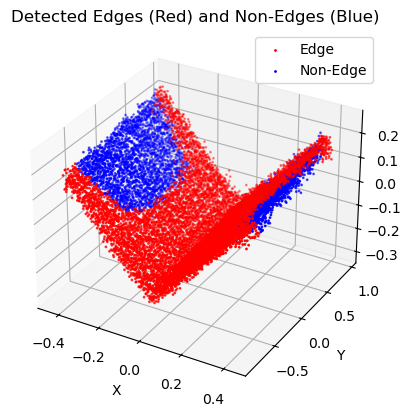

In [112]:
# Function to plot the point cloud with predicted edge and non-edge points
def plot_point_cloud_with_predictions(points, predictions):
    

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()


    if predictions.ndim == 1:
        predictions = predictions.reshape(-1)


    edges = points[predictions == 1]
    non_edges = points[predictions == 0]


    ax.scatter(edges[:, 0], edges[:, 1], edges[:, 2], c='r', label='Edge', s=1)


    ax.scatter(non_edges[:, 0], non_edges[:, 1], non_edges[:, 2], c='b', label='Non-Edge', s=1)


    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.legend()
    plt.title("Detected Edges (Red) and Non-Edges (Blue)")
    

    plt.show()

# provide Test point cloud file path
test_file = '/home/jovyan/dlrv_project_ws/test_Schmersal_AM-T100_2024-07-04_215814.npy'

# Load the test point cloud
data = np.load(test_file)
points = data[:, :3] 


points = normalize_point_cloud(points)


points_tensor = torch.FloatTensor(points).unsqueeze(0).to(device) 

model = PointNetPlusPlus().to(device)
model.load_state_dict(torch.load('edgesegment_pointnet_model.pth')) #load the model using correct path
with torch.no_grad():
    outputs = model(points_tensor)
    print(f"Model output shape: {outputs.shape}")
    

    if outputs.ndimension() == 3:  
        outputs = outputs.squeeze(-1)  

    predictions = torch.round(torch.sigmoid(outputs)).squeeze()  # [num_points]


if predictions.ndimension() == 1:
    predictions = predictions.cpu().numpy()
else:
    predictions = predictions.squeeze().cpu().numpy()


# Plot the point cloud with predicted edges and non-edges
plot_point_cloud_with_predictions(points, predictions)


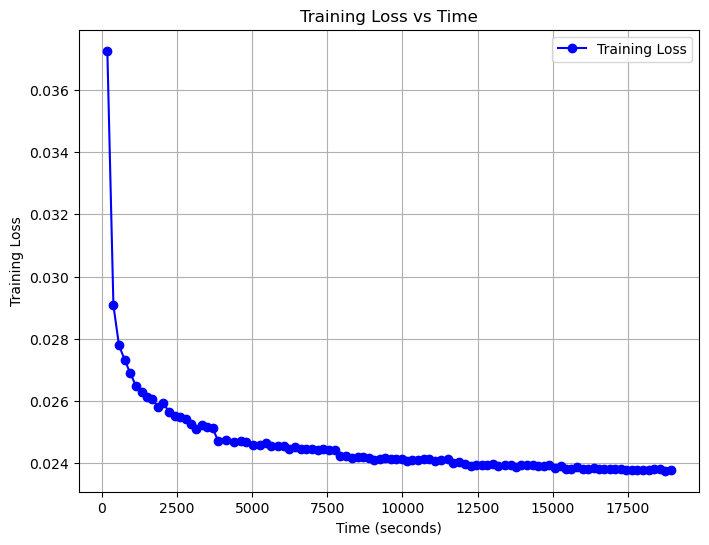

In [123]:

file_path= r'/home/jovyan/dlrv_project_ws/training_time_vs_loss.csv' #provide the correct filepath for the same
data = pd.read_csv(file_path)

# Plot training loss vs time
plt.figure(figsize=(8, 6))
plt.plot(data['Elapsed Time (s)'], data['Train Loss'], label='Training Loss', color='blue', marker='o')
plt.xlabel('Time (seconds)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Time')
plt.legend()
plt.grid(True)
plt.show()